In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
import numpy as np
import sys
sys.path.append("../pose_chiral/")  
from matplotlib.cm import get_cmap

In [3]:
# Helper functions 
def visualize_pose(x):
    colors = ['r', 'b', 'gray']
    label = ['left', 'right', 'center']
    # Plot limbs.
    plt.plot([x[0,0], x[2,0]], [x[0,1], x[2,1]], 'k', linewidth=3)
    plt.plot([x[1,0], x[2,0]], [x[1,1], x[2,1]], 'k', linewidth=3)
    for joint_idx, xy_idx in enumerate(x):
        if joint_idx == 2:
            plt.scatter(xy_idx[0], xy_idx[1], s=1000, c=colors[joint_idx], label=label[joint_idx])
        else:
            plt.scatter(xy_idx[0], xy_idx[1], s=700, marker='s', c=colors[joint_idx], label=label[joint_idx])
def get_group_lists(self, sym_grouping):                                        
    """Gets the index list for left and right groups."""                          
    left_idx = [k for k in range(sym_grouping[0])]                                
    right_list = [k + sym_grouping[0] for k in range(sym_grouping[1])]            
    return left_idx, right_list   

def chiral_transform(x, sym_grouping=[1,1,1], neg_dim_in=1):
    x_out = np.array(x)
    # Negate the neg_dimensions.
    x_out[:, :neg_dim_in] *= -1 
    left_idx, right_idx = get_group_lists(sym_grouping, sym_grouping)
    x_out[left_idx+right_idx, :] = x_out[right_idx+left_idx,:] 
    return x_out

# Tutorial on Chiral Equivariance
In this notebook, we illustrate the concept of chiral equivariance and demonstate the proposed layers which satisfy the chiral equivariance property.

We start with a simple example, where the pose consists of three 2D points, as illustrated below:

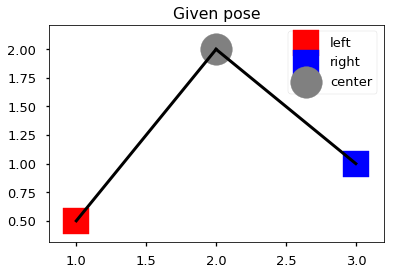

In [4]:
plt.figure()
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
visualize_pose(x)
plt.title('Given pose')
t=plt.legend()

## Chirality transform $\mathcal{T}$
We visualize the chirality transformation. This involves a negation of the "x-coordinate" and a swap between the left and right joints.

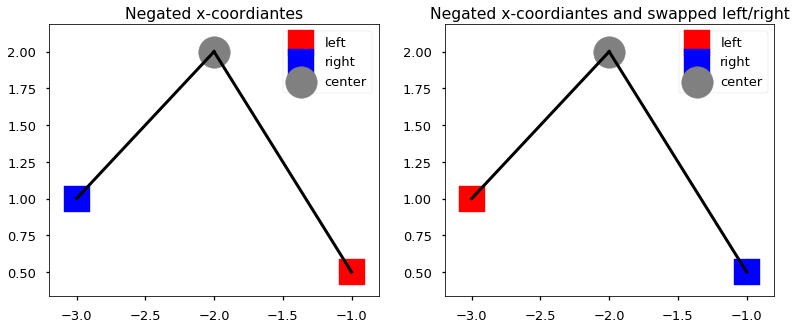

In [5]:
# Performs and visualize negation
plt.figure(figsize=(13,5))
plt.subplot(121)
x_left, x_right, x_center = [-1,0.5], [-3,1], [-2,2]
x = np.array([x_left, x_right, x_center])
visualize_pose(x)
plt.title('Negated x-coordiantes')
plt.legend()
plt.subplot(122)
# Performs and visualize the negation and swap
x_left, x_right, x_center = [-3,1], [-1,0.5], [-2,2]
x = np.array([x_left, x_right, x_center])
visualize_pose(x)
plt.title('Negated x-coordiantes and swapped left/right')
t=plt.legend()

We visualize, side by side, the pose before and after the transformation.

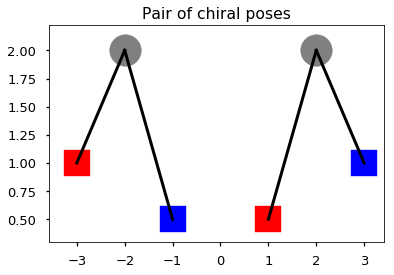

In [6]:
plt.figure()            
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
visualize_pose(x)
x_chiral = chiral_transform(x)  # We condense the two operations into one.
visualize_pose(x_chiral)
t=plt.title('Pair of chiral poses')

## Chirality Equivariance
At a high level, equivariance of a function means, if the input of the function is transformed in a "predefined way", then the output is also transformed in a "predefined way". Formally,  we say a function $F_\theta$ is chirality equivariant with respect to $(\mathcal{T^{\tt in}, T^{\tt out}})$ if 
$$\mathcal{T}^{\tt out}(F_\theta(\mathbf{x})) = F_\theta(\mathcal{T}^{\tt in}(\mathbf{x})) \;\; \forall \mathbf{x}.$$

In the following illustration, we set $\mathcal{T^{\tt in}}$ to be equal to $\mathcal{T^{\tt out}}$ and we drop the in/out for simplicity.

We start with a simple function, $f(\mathbf{x}) = 2 \cdot \mathbf{x}$. It is easy to see from the cummilative property of multiplication, $$\mathcal{T}(2 \cdot \mathbf{x}) = 2\cdot(\mathcal{T}(\mathbf{x})) \;\; \forall \mathbf{x}$$
We visualize the equivariance below and observe that the two results are identitcal:

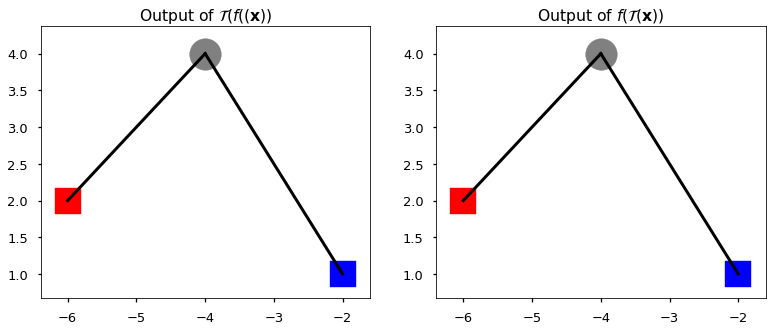

In [7]:
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
# F first
fx = 2*x
tfx = chiral_transform(fx)
# T first.
tx = chiral_transform(x)
ftx = 2*tx
plt.figure(figsize=(13,5))
plt.subplot(121)
visualize_pose(tfx)
t=plt.title('Output of $\mathcal{T}(f((\mathbf{x}))$')
plt.subplot(122)
visualize_pose(ftx)
t=plt.title('Output of $f(\mathcal{T}(\mathbf{x})$)')

## Chirality Equivariant Fully Connected Layers
In the following, we visualize the inner workings of our proposed fully connected layer that satisfies the equivariance property on this toy example. 
**We have also included implementation for other layers with tests cases.
For mathemathetical proofs of these layers, please refer to the PDF included in the supplementary.**

First, we validated that our proposed chiral fully connected layer satisfies the chiral equivariance property.
Below we visualize the results:

Creating a chiral fully connected layer.
```python
import torch
from chiral_layers.chiral_linear import ChiralLinear
# Creates a chiral fully connected layer
num_joints = 3
in_channels = 2*num_joints
out_channels = 2*num_joints
# [1,1,1] indicates a left joint, a right joint and a center joint.
# [2,2,1] indicates two left joints, two right joints and a center joint...etc.
sym_groupings = ([1,1,1],[1,1,1])  
linear_layer = ChiralLinear(in_channels, out_channels,sym_groupings=sym_groupings)
```

(1) Computing $\mathcal{T}(f((\mathbf{x}))$:
```python
# Compute T(f(x))
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
x_vector = torch.from_numpy(np.expand_dims(np.reshape(x,-1),0)).float()
fx = linear_layer(x_vector)
fx = fx.data.cpu().numpy()
fx = np.reshape(fx,(num_joints,2))
tfx = chiral_transform(fx)
```
(2) Computing $f(\mathcal{T}(\mathbf{x}))$:
```python
# Compute f(T(x))
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
tx = chiral_transform(x)
tx_vector = torch.from_numpy(np.expand_dims(np.reshape(tx,-1),0)).float()
ftx = linear_layer(tx_vector)
ftx = ftx.data.cpu().numpy()
ftx = np.reshape(ftx,(num_joints,2))
```
Observe that the two results are identical, thus satisfying the equivariance property.

In [8]:
import torch
from chiral_layers.chiral_linear import ChiralLinear
# Declare a chiral fully connected layer
num_joints = 3
in_channels = 2*num_joints
out_channels = 2*num_joints
sym_groupings = ([1,1,1],[1,1,1])
linear_layer = ChiralLinear(in_channels, out_channels, sym_groupings=sym_groupings, neg_dim_in=1, neg_dim_out=1)

In [9]:
# Compute T(f(x))
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
x_vector = torch.from_numpy(np.expand_dims(np.reshape(x,-1),0)).float()
fx = linear_layer(x_vector)
fx = fx.data.cpu().numpy()
fx = np.reshape(fx,(num_joints,2))
tfx = chiral_transform(fx)

In [10]:
# Compute f(T(x))
x_left, x_right, x_center = [1,0.5], [3,1], [2,2]
x = np.array([x_left, x_right, x_center])
tx = chiral_transform(x)
tx_vector = torch.from_numpy(np.expand_dims(np.reshape(tx,-1),0)).float()
ftx = linear_layer(tx_vector)
ftx = ftx.data.cpu().numpy()
ftx = np.reshape(ftx,(num_joints,2))

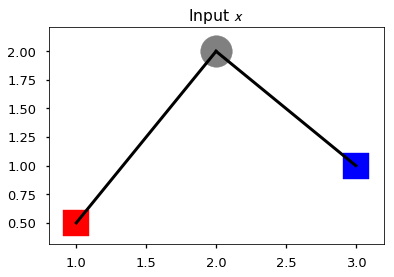

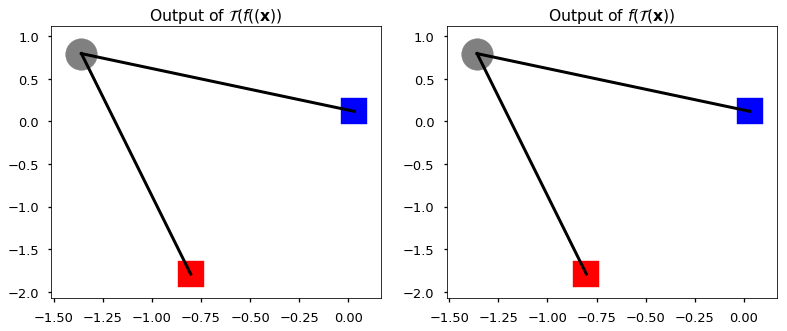

In [11]:
visualize_pose(x)
t=plt.title('Input $\mathcal{x}$')
plt.figure(figsize=(13,5))
plt.subplot(121)
visualize_pose(tfx)
t=plt.title('Output of $\mathcal{T}(f((\mathbf{x}))$')
plt.subplot(122)
visualize_pose(ftx)
t=plt.title('Output of $f(\mathcal{T}(\mathbf{x})$)')

We illustrate the parameter sharing scheme that achieves the chiral equvariance. See section 3.3 for details.

Recall the computation of a fully connected layer is as follows:
$$\mathbf{y} = f_{\text{FC}}(\mathbf{x} ; W, b) := W\mathbf{x} + b$$

We visualize the magnitude  of the weights, $|W|$. Observe that the blocks highlighted in the same color share parameters.

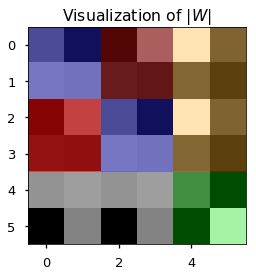

In [12]:
import matplotlib.patches as patches
big_w_m, big_b_m = linear_layer.get_masked_weight()
big_w_m = big_w_m.data.cpu().numpy()
big_b_m = big_b_m.unsqueeze(1).data.cpu().numpy()

cmap = get_cmap('binary_r')
fig,ax = plt.subplots(1)
ax.imshow(np.abs(big_w_m),cmap=cmap)
rect = patches.Rectangle((-0.5,-0.5),2,2,linewidth=0,edgecolor='b',facecolor='b', alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((2-0.5,2-0.5),2,2,linewidth=0,edgecolor='b',facecolor='b', alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((2-0.5,-0.5),2,2,linewidth=0,edgecolor='r',facecolor='r',alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((-0.5,2-0.5),2,2,linewidth=0,edgecolor='r',facecolor='r',alpha=0.3)
ax.add_patch(rect)
ax.add_patch(rect)
rect = patches.Rectangle((4-0.5,-0.5),2,2,linewidth=0,edgecolor='y',facecolor='orange',alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((4-0.5,2-0.5),2,2,linewidth=0,edgecolor='y',facecolor='orange',alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((4-0.5,4-0.5),2,2,linewidth=0,edgecolor='y',facecolor='lime',alpha=0.3)
ax.add_patch(rect)
t=plt.title('Visualization of $|W|$')

Next, we visualize the enforced odd symmetry. For example, *e.g.*, the upper right parameter of the top-left blue block has to be negation of the upper right parameter of the center blue block. This ensures that "x-coordinates" are negated at the output. See detail description in Section 3.3 of the paper.

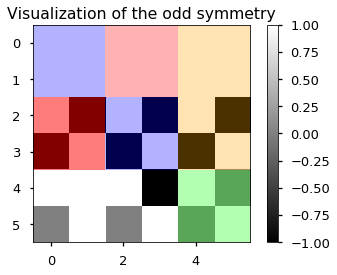

In [13]:
big_w_m, big_b_m = linear_layer.get_masked_weight()
big_w, big_b = linear_layer.get_weight_()
big_w_m = big_w_m.data.cpu().numpy()
big_b_m = big_b_m.unsqueeze(1).data.cpu().numpy()
big_w = big_w.data.cpu().numpy()
big_b = big_b.unsqueeze(1).data.cpu().numpy()

fig,ax = plt.subplots(1)
cax = ax.imshow(big_w_m/big_w,cmap=cmap)
fig.colorbar(cax)
rect = patches.Rectangle((-0.5,-0.5),2,2,linewidth=0,edgecolor='b',facecolor='b', alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((2-0.5,2-0.5),2,2,linewidth=0,edgecolor='b',facecolor='b', alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((2-0.5,-0.5),2,2,linewidth=0,edgecolor='r',facecolor='r',alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((-0.5,2-0.5),2,2,linewidth=0,edgecolor='r',facecolor='r',alpha=0.3)
ax.add_patch(rect)
ax.add_patch(rect)
rect = patches.Rectangle((4-0.5,-0.5),2,2,linewidth=0,edgecolor='y',facecolor='orange',alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((4-0.5,2-0.5),2,2,linewidth=0,edgecolor='y',facecolor='orange',alpha=0.3)
ax.add_patch(rect)
rect = patches.Rectangle((4-0.5,4-0.5),2,2,linewidth=0,edgecolor='y',facecolor='lime',alpha=0.3)
ax.add_patch(rect)
t=plt.title('Visualization of the odd symmetry')